# Validate Classifier

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from IPython.display import Image
from PIL import Image
from matplotlib import cm
from tensorflow.python.client import device_lib

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import label_image
import glob
import math

import tensorflow as tf

#print(device_lib.list_local_devices())

In [17]:
def get_image_list(folder):
    image_list = {}
    for directory in glob.glob(folder+'/*/'):
        images = []
        for filename in glob.glob(str(directory)+'*.jpg'): #assuming jpg
            images.append(filename)
        image_list.update({str(directory[directory.find('\\')+1:directory.rfind('\\')]):images})
    return image_list

def classify_cells(image_directory,model_file, 
                   label_file= "output_files/output_labels.txt", 
                   input_height=224, 
                   input_width=224,
                   input_mean=0,
                   input_std=255, 
                   input_layer='Placeholder',
                   output_layer= 'final_result'):    
    print('\nClassifying directory...'+str(image_directory),'....')
    image_list = get_image_list(image_directory)
    graph = label_image.load_graph(model_file)
    
    #dict of validation images.
    val_set = {}
    print('READING IMAGES....')
    for key in image_list.keys():
        print(key+'.....',end='')
        val_images = []
        for file_name in image_list[key]:
            val_images.append(label_image.read_tensor_from_image_file(
                file_name,
                input_height=input_height,
                input_width=input_width,
                input_mean=input_mean,
                input_std=input_std))
        val_set.update({str(key):val_images})
        print('.....done')


    input_name = "import/" + input_layer
    output_name = "import/" + output_layer
    input_operation = graph.get_operation_by_name(input_name)
    output_operation = graph.get_operation_by_name(output_name)
    
    print('MAKING PREDICTIONS....')
    predictions = {}
    for key in val_set.keys():
        print(key+'.....',end='')
        val_pred = []
        for img in val_set[key]:
            with tf.Session(graph=graph) as sess:
                results = sess.run(output_operation.outputs[0], {
                input_operation.outputs[0]: img
                })
                results = np.squeeze(results)

            val_pred.append(results.argsort()[-5:][::-1][0])
        predictions.update({key:val_pred})
        print('.....done')
    labels = label_image.load_labels(label_file)
    return predictions, labels

def confusion_matrix(predictions,labels,image_directory,title=None):
    n=len(labels)
    confusion_matrix = np.zeros((n,n), dtype=np.float)
    image_list = get_image_list(image_directory)
    
    pred_scores=[]
    misclassified = []
    for i,ctype in enumerate(labels):
        err,num = 0.0,0
        for j,pred in enumerate(predictions[ctype]):
            confusion_matrix[pred,i]+=1/len(predictions[ctype])
            num+=1
            if(pred!=i):
                misclassified.append(image_list[ctype][j])
                err+=1
        pred_scores.append(((num-err)/num,num))

    for i,label in enumerate(labels):
        print(label,'= ', str(round(pred_scores[i][0]*100,1))+'%,',pred_scores[i][1],'samples')

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    cfm = ax.matshow(confusion_matrix, cmap=plt.cm.get_cmap('hot',50))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    plt.colorbar(cfm, cax=cax, ticks=np.arange(0,1.1,.1))

    ax.set_xlabel('Cell Type', fontsize=20)
    ax.set_ylabel('Prediction', fontsize=20)
    ax.set_xticklabels(['']+labels, fontsize=12)
    ax.set_yticklabels(['']+labels, fontsize=12)
    ax.xaxis.set_label_position('top')
    ax.xaxis.labelpad = 20
    ax.yaxis.labelpad = 20

    fig.tight_layout(pad=0, w_pad=1.5, h_pad=3)
    fig.set_figheight(10)
    fig.set_figwidth(10)
    fig.suptitle(title, fontsize=26)
    return misclassified
    
def vis_images(images):
    #fig, axes = plt.subplots((len(images),1))
    num=len(images)
    
    n_columns = 2
    n_rows = math.ceil(num / n_columns) + 1
    fig = plt.figure(1, figsize=(n_columns*8, n_rows*6))
    for i,img in enumerate(images):
        plt.subplot(n_rows, n_columns, i+1)
        plt.title('File: '+img,fontsize=16)
        plt.imshow(plt.imread(img))
    plt.tight_layout()
    
        
    

### Trained models

In [4]:
# If not available in repo, first generate using retrain_helper.ipynb
inception_v1 = "output_files/output_graph_inception_v1.pb" # Final Test Accuracy: 90.0%
inception_v1_p = "output_files/output_graph_inception_v1_partial.pb" # Final Test Accuracy: 89.0%
inception_v1_original_set_distort = "output_files/output_graph_inception_v1_original_set_distort.pb" # Final Test Accuracy: 90.2%
inception_v3_original_set_adam_0001_feature = "output_files/output_graph_inception_v3_original_set_adam_0001_feature.pb"


inception_v2 = "output_files/output_graph_inception_v2.pb" # Final Test Accuracy: 90.0%. Not available in repo.

inception_v3 = "output_files/output_graph_inception_v3.pb" # Final Test Accuracy: 94.3%. Not available in repo.
inception_v3_original_set = "output_files/output_graph_inception_v3_original_set.pb" # Final Test Accuracy: 94.3%. Not available in repo.
inception_v3_original_set_adam = "output_files/output_graph_inception_v3_original_set_adam.pb"
inception_v3_original_set_adam_0002 = "output_files/output_graph_inception_v3_original_set_adam_0002.pb"
inception_v3_original_set_adam_0001 = "output_files/output_graph_inception_v3_original_set_adam_0001.pb"
inception_v3_original_set_adam_0001_b200 = "output_files/output_graph_inception_v3_original_set_adam_0001_b200.pb"
inception_v3_original_set_adam_00005 = "output_files/output_graph_inception_v3_original_set_adam_00005.pb"
inception_v3_original_set_adam_00005_a = "output_files/output_graph_inception_v3_original_set_adam_00005_a.pb"
inception_v3_original_set_adam_00005_feature = "output_files/output_graph_inception_v3_original_set_adam_00005_feature.pb"
inception_v3_original_set_adam_0001_feature_alltrain = "output_files/output_graph_inception_v3_original_set_adam_0001_feature_alltrain.pb"
inception_v3_original_set_adam_00005_feature_alltrain = "output_files/output_graph_inception_v3_original_set_adam_00005_feature_alltrain.pb"
inception_v3_original_set_adam_00005_feature_alltrain2_7k = "output_files/output_graph_inception_v3_original_set_adam_00005_feature_alltrain2_7k.pb"


inception_v3_original_set_adam_00005_distort = "output_files/output_graph_inception_v3_original_set_adam_00005_distort.pb"
inception_v3_original_set_adam_000025 = "output_files/output_graph_inception_v3_original_set_adam_000025.pb"
inception_v3_original_set_adam_000025_b32 = "output_files/output_graph_inception_v3_original_set_adam_000025_b32.pb"
inception_v3_original_set_adam_000025_b32_30k = "output_files/output_graph_inception_v3_original_set_adam_000025_b32_30k.pb"
inception_v3_original_set_adam_00005_b32 = "output_files/output_graph_inception_v3_original_set_adam_00005_b32.pb"

mobilenet_v1 = 'output_files/output_graph_mobilenet_v1.pb' # Final Test Accuracy: 94.3%
mobilenet_v1_original_set = 'output_files/output_graph_mobilenet_v1_original_set.pb' # Final Test Accuracy: 94.7% 

mobilenet_v2 = 'output_files/output_graph_mobilenet_v2.pb' # Final Test Accuracy: 92.2% 

inception_resnet_v2 = 'output_files/output_graph_inception_resnet_v2.pb' # Final Test Accuracy: 86.4%. Not available in repo.

#### Choose directory of images to classify and Model to use for classification (model_file)...

In [5]:
unseen_dir = 'images/original_set/unseen_validation'
train_dir = 'images/original_set/training_cell_type_images'
model_file = inception_v3_original_set_adam_0001_feature_alltrain

# other paramaters with default values
label_file = "output_files/output_labels.txt"
input_height = 299
input_width = 299
input_mean = 0
input_std = 255
input_layer = 'Placeholder'
output_layer = 'final_result'

#### Run Prediction...

In [6]:
#Unseen Validation Set
unseen_predict, labels = classify_cells(unseen_dir,model_file, input_height=input_height, input_width=input_width)


Classifying directory...images/original_set/unseen_validation ....
READING IMAGES....
actinedge..........done
filopodia..........done
hemisphere..........done
lamellipodia..........done
smallbleb..........done
MAKING PREDICTIONS....
actinedge..........done
filopodia..........done
hemisphere..........done
lamellipodia..........done
smallbleb..........done


### Visualize Confusion Matrix

actinedge =  57.1%, 7 samples
filopodia =  77.8%, 9 samples
hemisphere =  66.7%, 3 samples
lamellipodia =  90.9%, 11 samples
smallbleb =  100.0%, 6 samples


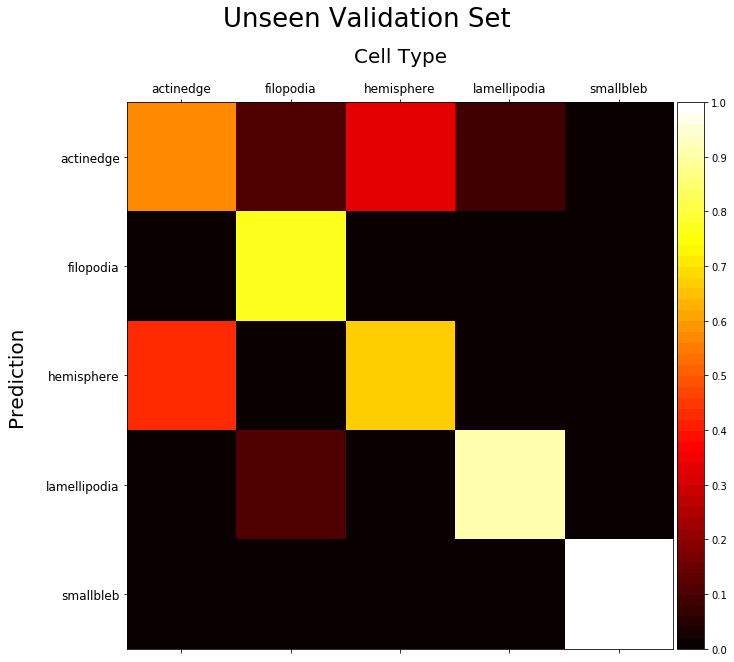

In [7]:
misclassified = confusion_matrix(unseen_predict, labels, unseen_dir, title='Unseen Validation Set')

### Display Misclassified Images

images/original_set/unseen_validation\actinedge\cell5.jpg
images/original_set/unseen_validation\actinedge\cell6.jpg
images/original_set/unseen_validation\actinedge\cell7.jpg
images/original_set/unseen_validation\filopodia\cell2.jpg
images/original_set/unseen_validation\filopodia\cell9.jpg
images/original_set/unseen_validation\hemisphere\cell1.jpg
images/original_set/unseen_validation\lamellipodia\cell10.jpg


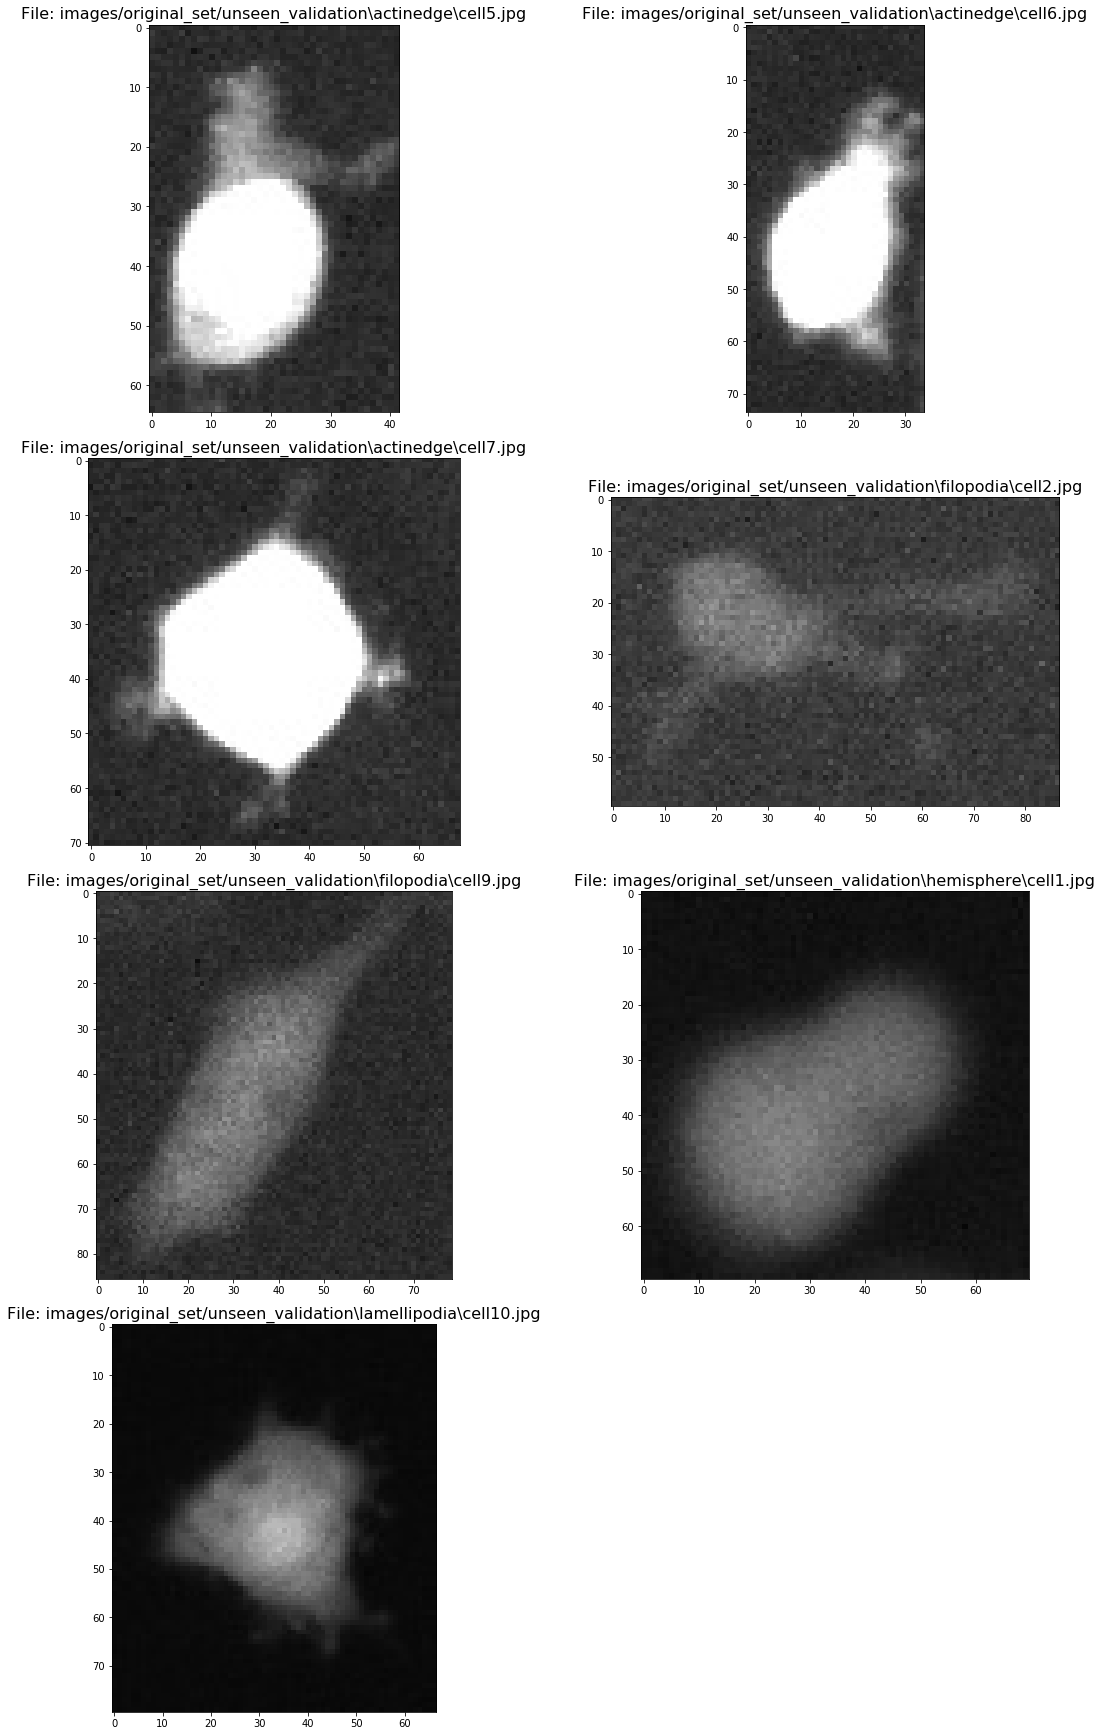

In [18]:
for x in misclassified:
    print(x)
vis_images(misclassified)

## Check Training Set Classification Accuracy

In [12]:
#Training Set
train_predict, labels = classify_cells(train_dir,model_file)


Classifying directory...images/original_set/training_cell_type_images ....
reading images....
actinedge..........done
filopodia..........done
hemisphere..........done
lamellipodia..........done
smallbleb..........done
making predictions....
actinedge..........done
filopodia..........done
hemisphere..........done
lamellipodia..........done
smallbleb..........done


actinedge =  97.7%, 131 samples
filopodia =  99.8%, 460 samples
hemisphere =  97.7%, 86 samples
lamellipodia =  98.0%, 399 samples
smallbleb =  99.5%, 222 samples


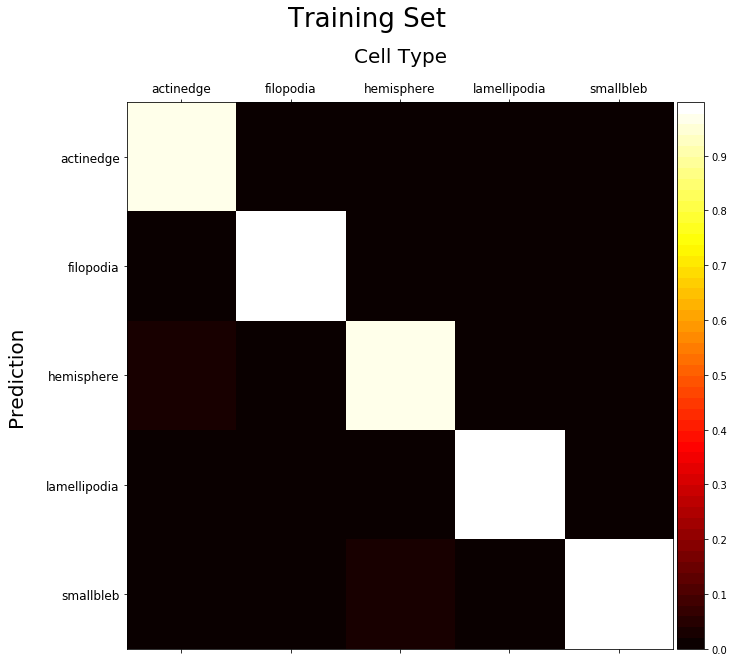

In [13]:
confusion_matrix(train_predict, labels, title='Training Set')